In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv

In [7]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")

In [8]:
data = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')


array([[           nan, 2.84880000e-02, 3.53465834e+01, 2.23905933e-01,
        1.28418942e-01],
       [           nan, 5.00430000e-02, 3.66823679e+01, 1.66828851e-01,
        1.28418942e-01],
       [           nan, 5.29260000e-02, 3.68176913e+01, 1.55755915e-01,
        1.28418942e-01],
       ...,
       [           nan, 8.21000000e-01, 4.36409388e+01, 1.94013592e-01,
        5.51671793e-01],
       [           nan, 1.21500000e+00, 4.52465209e+01, 5.60317445e-01,
        1.47652666e-04],
       [           nan, 6.23000000e-01, 4.25145240e+01, 2.41428135e-01,
        5.51671793e-01]])

In [107]:
redshift = data.T[1]
dist_mod = data.T[2] #pc
dist_mod_err = data.T[3] #pc

redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
# horizon distance
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


<ipython-input-107-6e7d78efc224>:14: RuntimeWarning: divide by zero encountered in true_divide
  m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)
<ipython-input-107-6e7d78efc224>:14: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


In [108]:
def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  # what if this goes negative?
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms

Matter Density is: 0.0
Dark Energy Density is: 0.0


/Users/tanaybhadra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/tanaybhadra/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


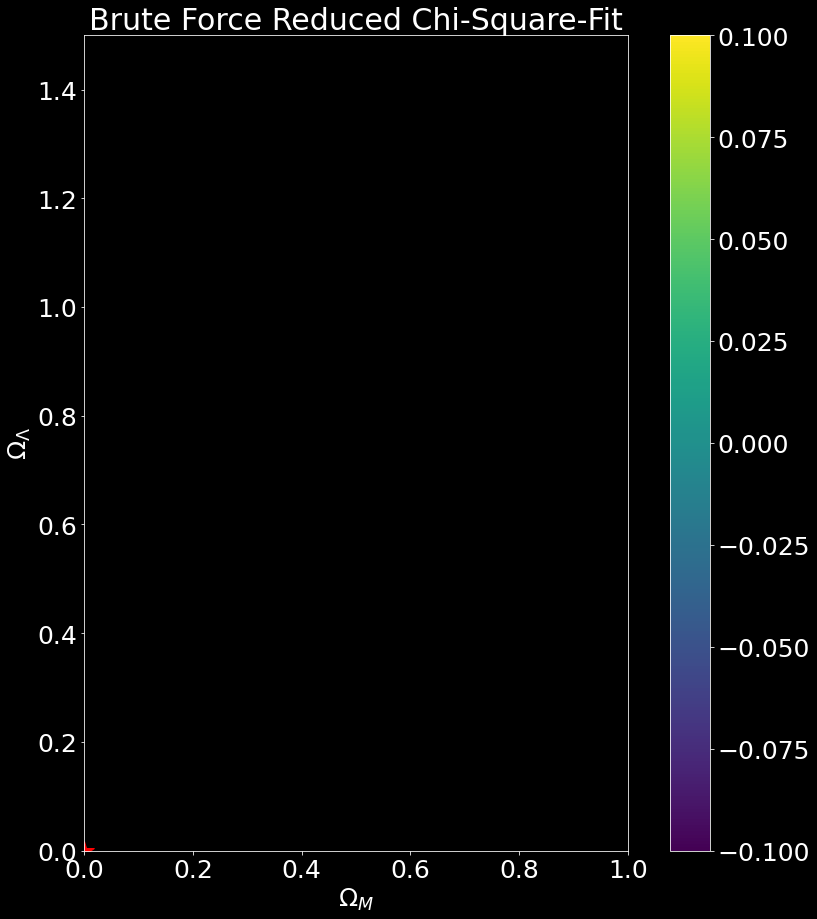

In [109]:

# construct a 2D grid in Om_M, Om_Lambda:
Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

# initialize a chisq surface in this space: 
Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

# loop over points (cosmologies) in this space
for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
    # get predicted magnitudes for this cosmology
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        # construct a chisq between the theory and the data
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        # print omega_m,omega_L,omega_k,chisq,ndof
        Z[j,i] = min(chisq,Zmax)

# find the minimum chisq
chimin = Z.min()
# and the values of the parameters at the minimum
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

# find the contour of "no big bang"
b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

# plot the chisq and contours
plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
CS = plt.contour(X, Y, Z)
CS.levels = [chimin+1., chimin+2., chimin+3.]
# plot the minimum
plt.plot(X[am],Y[am],'r*',markersize=20)
# plot the "no big bang" boundary
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit')
plt.show()

# SNLS Data

Matter Density is: 0.13559322033898305
Dark Energy Density is: 0.5561797752808989


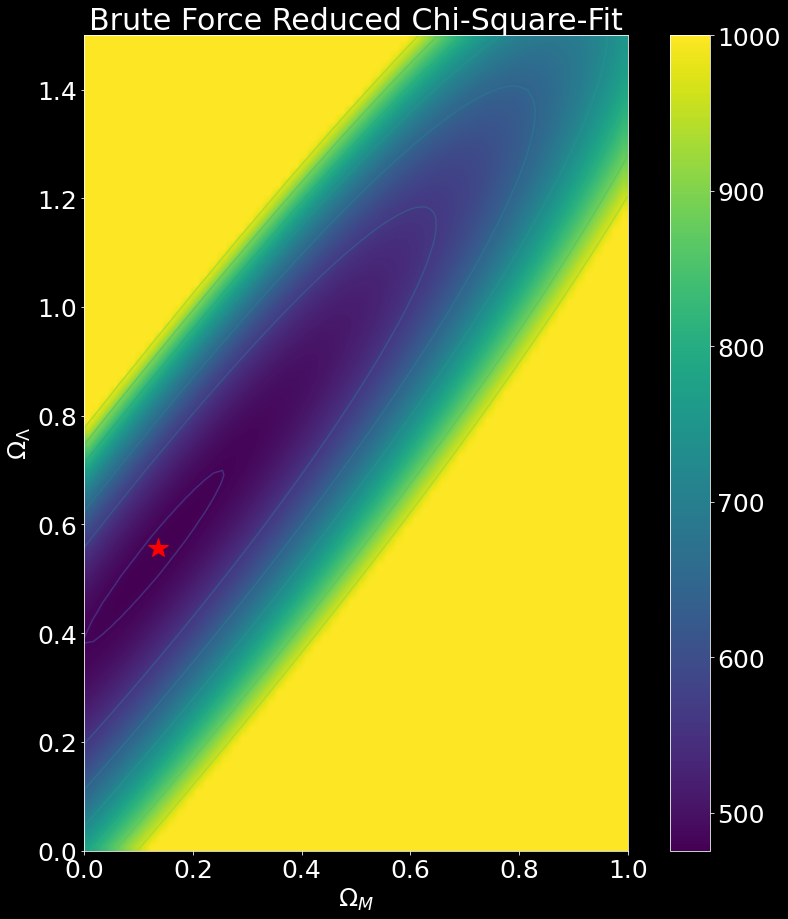

In [106]:
data = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift = data.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data.T[4]
color_measure = data.T[8]
stretch_factor = data.T[6]
stretch_factor_error = data.T[7]
b_band_lum_err = data.T[5]
redshift = data.T[1]
color_error = data.T[9]
dist_mod = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)


redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
# horizon distance
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  # what if this goes negative?
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms


# construct a 2D grid in Om_M, Om_Lambda:
Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

# initialize a chisq surface in this space: 
Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

# loop over points (cosmologies) in this space
for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
    # get predicted magnitudes for this cosmology
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        # construct a chisq between the theory and the data
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        # print omega_m,omega_L,omega_k,chisq,ndof
        Z[j,i] = min(chisq,Zmax)

# find the minimum chisq
chimin = Z.min()
# and the values of the parameters at the minimum
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

# find the contour of "no big bang"
b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

# plot the chisq and contours
plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
CS = plt.contour(X, Y, Z)
CS.levels = [chimin+1., chimin+2., chimin+3.]
# plot the minimum
plt.plot(X[am],Y[am],'r*',markersize=20)
# plot the "no big bang" boundary
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit')
plt.show()

# HyperLeda Phase Space

In [85]:
import pandas as pd

In [93]:
df = pd.read_csv('HyperLeda_Updated.csv').dropna()
df = df.where(df.where(df['mod_mpc']<120).dropna()['v_gsr']<15000).dropna()
df = df.where(df['v_gsr']/3e5>0).dropna()
df

,objname,e_mod0,mod0,v_gsr,mod_mpc
3,PGC1059326,0.540,34.160,2701.8,67.920363
11,PGC1809186,0.346,35.066,9386.2,103.086074
12,PGC1824266,0.035,30.230,404.8,11.117317
13,PGC2601822,0.200,28.660,253.0,5.395106
14,PGC2793293,0.200,34.348,4478.2,74.062778
...,...,...,...,...,...
4231,IC3442,0.059,31.118,1198.0,16.734009
4232,IC3019,0.064,31.145,1615.3,16.943378
4233,UGC07854,0.045,30.978,913.7,15.689171
4234,UGC07399A,0.053,31.150,1371.1,16.982437


In [94]:
redshift = np.array(df['v_gsr']/3e5)
dist_mod = np.array(df['mod0'])
dist_mod_err = np.array(df['e_mod0'])

redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
# horizon distance
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


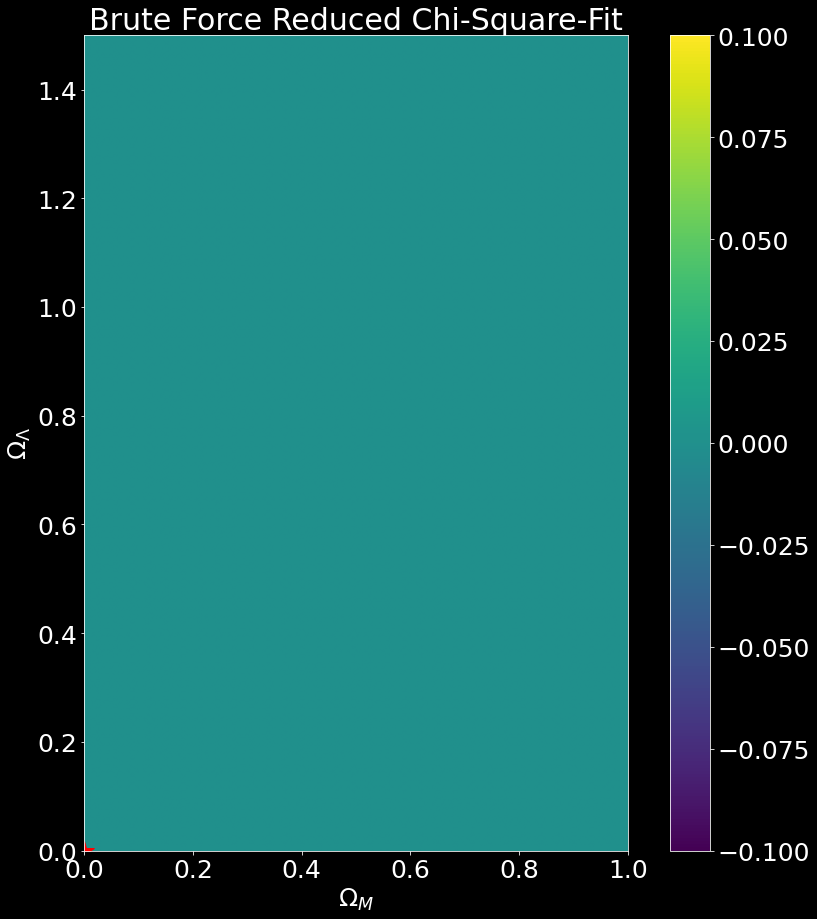

In [95]:

# construct a 2D grid in Om_M, Om_Lambda:
Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

# initialize a chisq surface in this space: 
Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

# loop over points (cosmologies) in this space
for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
    # get predicted magnitudes for this cosmology
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        # construct a chisq between the theory and the data
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        # print omega_m,omega_L,omega_k,chisq,ndof
        Z[j,i] = min(chisq,Zmax)

# find the minimum chisq
chimin = Z.min()
# and the values of the parameters at the minimum
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
mc = redshift_pred(omega_m,omega_L,redshift_guess)  

# find the contour of "no big bang"
b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

# plot the chisq and contours
plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
CS = plt.contour(X, Y, Z)
CS.levels = [chimin+1., chimin+2., chimin+3.]
# plot the minimum
plt.plot(X[am],Y[am],'r*',markersize=20)
# plot the "no big bang" boundary
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit')
plt.show()